<a href="https://colab.research.google.com/github/gpenessot/OCT23_BDS_Radios_Poumons/blob/main/4_Transfer_learning_%26_hyperparameter_tuning_VGG19_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet DST - Etape 3 Modélisation - Transfer learning

Notebook adapté du notebook commun "baseline - hyperparameter tuning"

## 1) Montage Drive & import librairies : à faire à chaque ouverture

In [1]:
# Connection du notebook au google drive perso

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Installation du keras tuner dans l'environnement du notebook car pas installé par défaut

!pip install keras-tuner -q
import keras_tuner
from keras_tuner.tuners import  Hyperband

In [75]:
# Import des packages / librairies / fonctions nécessaires

import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import cv2
import zipfile
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam



from keras.callbacks import EarlyStopping

#Ajouts Thibaut :
import pickle #pour sauvegarde de l'historique d'entraînement
import os
import pandas as pd
#pour le Grad-CAM
from IPython.display import Image, display
import matplotlib
import matplotlib.cm as cm

## 2) Dézippage sets d'images : fait 1 fois

In [4]:
# Dézippage des sets d'images (stockés sur google drive) dans l'environnement du notebook

# Dézippage train set
!unzip -q '/content/drive/MyDrive/Colab/TrainTest.zip'

## 3) Import des datasets

In [76]:
#A MODIFIER PAR L'UTILISATEUR : Paramétrage des dossiers locaux pour les datasets et les sauvegardes :

# Chemin du dossier TRAIN dézippé : à adapter si stocké ailleurs
dossier_train = "/content/Train/"

# Chemin du dossier TEST dézippé : à adapter si stocké ailleurs
dossier_test = "/content/Test"

#Dossier de sauvegarde du modèle au format.keras et de l'historique d'entraînement au format pickle
dossier_sauv = "/content"

#Nom du dataset (arbitraire), pour intégrer dans le nom de la sauvegarde et s'y retrouver plus facilement
#N'a pas de rapport avec le nom du dossier
nom_dataset = "TrainTest"

In [77]:
# Affichage du lien du répertoire du set d'entrainement
train_set_dir = pathlib.Path(dossier_train).with_suffix('')

# Vérification nombre d'images dans le set d'entrainement
print ("Répertoire train set : ", train_set_dir)
train_set_image_count = len(list(train_set_dir.glob('*/*.png')))
print("Nombre images train set ", train_set_image_count)

print ("\n")

# Affichage du lien du répertoire du set de test
test_set_dir = pathlib.Path(dossier_test).with_suffix('')

# Vérification nombre d'images dans le set de test
print ("Répertoire test set : ", test_set_dir)
test_set_image_count = len(list(test_set_dir.glob('*/*.png')))
print("Nombre images test set ", test_set_image_count)

Répertoire train set :  /content/Train
Nombre images train set  4304


Répertoire test set :  /content/Test
Nombre images test set  1076


## 3) Paramètres globaux

In [78]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
MODE = 'rgb'   # rgb or grayscale

AUGMENTATION_ON = False

NUM_EPOCHS = 20
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
L_RATE = 0.001

NAME_TO_SAVE = "LeNet_arbitrary"

keras_tuner_logs_dir = "keras_tuner/logs"

CALLBACKS = [
    tf.keras.callbacks.ModelCheckpoint(NAME_TO_SAVE+'.weights.h5', save_best_only=True,save_weights_only=True, monitor="val_accuracy"),
    tf.keras.callbacks.ReduceLROnPlateau( monitor="val_accuracy", factor=0.2, patience=6, min_lr=0.000000001),
    tf.keras.callbacks.TensorBoard('keras_tuner/log')]

In [79]:
# Création des sets d'entrainement et de validation au format keras
# Attention : modèles de transfer learning requièrent du RGB en input

# Création du set d'entrainement
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
  train_set_dir,
  validation_split=VALIDATION_SPLIT,
  subset="both",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  color_mode=MODE,
 # color_mode = "rgb", #pour les modèles de transfer_learning
  batch_size=BATCH_SIZE,
  label_mode= 'categorical')


# Création du set de validation
test_ds = tf.keras.utils.image_dataset_from_directory(
  train_set_dir,
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  color_mode=MODE,
#  color_mode = "rgb", #pour les modèles de transfer_learning
  batch_size=BATCH_SIZE,
  label_mode= 'categorical')

    #Configure dataset for performance with CACHE (not loading images at each epoch)
    #and PREFETCH (overlapping data processing and model execution)



Found 4304 files belonging to 4 classes.
Using 3444 files for training.
Using 860 files for validation.
Found 4304 files belonging to 4 classes.


## 4) Transfer learning sans tuning

### Import d'un modèle pré-entraîné pour le transfer learning

In [80]:
inputs = tf.keras.Input(shape=(256, 256, 3))
x = keras.layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=30, kernel_size=(5, 5), padding='same', activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu', name = "Dense1")(x)
x = layers.Dense(128, activation='relu', name = "Dense2")(x)
x = layers.Dense(64, activation='relu', name = "Dense3")(x)
x = layers.Dense(4, activation = 'softmax', name = "Dense4")(x)

model = keras.Model(inputs, x)
model._name = NAME_TO_SAVE



### Compilation et entraînement

In [81]:
#Compilation
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=[keras.metrics.CategoricalAccuracy(name ='accuracy')])
model.summary()

Model: "LeNet_arbitrary"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling_3 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 256, 256, 30)      2280      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 128, 128, 30)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 16)      4336      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 64, 64, 16)        0         
 g2D)                                              

In [82]:
# Définition d'une callback qui stoppe le processus d'entrainement quand une valeur monitorée
# (ici la validation loss) stagne pendant un certain nombre d'epochs (et ce à partir d'un certain nombre d'epochs)

CALLBACKS = [
    tf.keras.callbacks.ModelCheckpoint(NAME_TO_SAVE+'.weights.h5', save_best_only=True,save_weights_only=True, monitor="val_accuracy"),
    tf.keras.callbacks.ReduceLROnPlateau( monitor="val_accuracy", factor=0.2, patience=6, min_lr=0.000000001),
    tf.keras.callbacks.TensorBoard("keras_tuner/logs")]

In [83]:
#Entraînement
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks = CALLBACKS )


Epoch 1/20
108/108 [==============================] - 10s 72ms/step - loss: 0.9665 - accuracy: 0.5598 - val_loss: 0.7938 - val_accuracy: 0.6570 - lr: 0.0010
Epoch 2/20
108/108 [==============================] - 6s 55ms/step - loss: 0.7119 - accuracy: 0.6954 - val_loss: 0.7809 - val_accuracy: 0.6628 - lr: 0.0010
Epoch 3/20
108/108 [==============================] - 12s 112ms/step - loss: 0.5046 - accuracy: 0.7915 - val_loss: 0.8627 - val_accuracy: 0.6698 - lr: 0.0010
Epoch 4/20
108/108 [==============================] - 7s 60ms/step - loss: 0.3253 - accuracy: 0.8653 - val_loss: 1.0504 - val_accuracy: 0.6779 - lr: 0.0010
Epoch 5/20
108/108 [==============================] - 8s 72ms/step - loss: 0.2081 - accuracy: 0.9236 - val_loss: 1.1914 - val_accuracy: 0.6721 - lr: 0.0010
Epoch 6/20
108/108 [==============================] - 6s 52ms/step - loss: 0.1317 - accuracy: 0.9498 - val_loss: 1.6831 - val_accuracy: 0.6570 - lr: 0.0010
Epoch 7/20
108/108 [==============================] - 7s 67ms

###

### Affichage des résultats et Enregistrement du modèle et des résultats

In [84]:
def plot_history_metrics(history,name_to_save):
 acc = history.history['accuracy']
 val_acc = history.history['val_accuracy']

 loss = history.history['loss']
 val_loss = history.history['val_loss']


 fig = plt.figure(figsize=(12,6))
 ax1 = fig.add_subplot(121)

 ax1.plot(acc, label='Training Accuracy')
 ax1.plot(val_acc, label='Validation Accuracy')
 ax1.legend(loc='lower right')
 ax1.set_title(name_to_save + 'Accuracy')

 ax2 = fig.add_subplot(122)
 ax2.plot(loss, label='Training Loss')
 ax2.plot(val_loss, label='Validation Loss')
 ax2.legend(loc='upper right')
 ax2.set_title( name_to_save + 'Loss')
 plt.show()

 fig.savefig('T&V' + name_to_save + '.png')
 plt.close(fig)

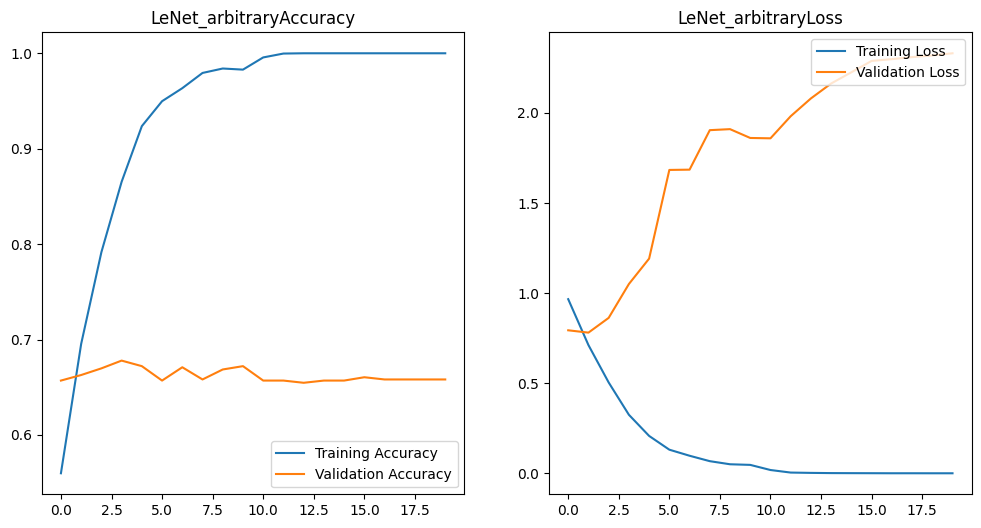

In [85]:
#Sauvegarde du modèle et des résultats

#Sauvegarde du modèle
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1

model.save('/content/'+ NAME_TO_SAVE + '.keras')

#Export results to dict & csv

#Dump to a pickle file
# Pickle the history to file
filepath = f"{NAME_TO_SAVE}_history.pkl"
filepath = os.path.join(dossier_sauv, filepath)
with open(filepath, 'wb') as f:
    pickle.dump(history, f)

#Impression du schéma
plot_history_metrics(history, NAME_TO_SAVE )

In [86]:
#Métriques sur jen d'entraînement
best_val_loss_index = np.argmin(history.history["val_loss"])
print("Best validation loss :", round(np.max(history.history["val_loss"]), 2) )
print("Validation ACCURACY : ", round(history.history["val_accuracy"][best_val_loss_index], 2))
print("Obtained at epoch : ", best_val_loss_index + 1)




Best validation loss : 2.33
Validation ACCURACY :  0.66
Obtained at epoch :  2


## 6) Evaluer le modèle sur un jeu de test

In [87]:
model.load_weights(NAME_TO_SAVE+'.weights.h5')

accuracy = model.evaluate(test_ds, return_dict=True)

print('TEST ACCURACY:',accuracy.get('accuracy'))

135/135 [==============================] - 4s 30ms/step - loss: 0.3806 - accuracy: 0.8731
TEST ACCURACY: 0.8731412887573242


## 7) Interprétabilité Grad-CAM

In [88]:
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions



### Paramètres à configurer selon le modèle


In [94]:
img_size = (256, 256)


model.layers[4].activation = None

last_conv_layer_name = "conv2d_7"



### Définition des fonctions



In [95]:
#Fonction pour charger une nouvelle image comme array pour injecter dans la fonction GradCam
def get_img_array(img_path, size):
    # `img` is a PIL image of size 256*256
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (256, 256, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 256,256, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [96]:
#Fonction grad_cam
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [97]:
def create_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.5):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = matplotlib.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    #display(Image(img_path))

    #Return superimposed_img
    return superimposed_img


### Test sur 1 image

1/1 [==============================] - 0s 99ms/step
/content/Train/COVID/COVID-156.png
Classe réelle :  COVID
Prédiction :  Viral_Pneumonia


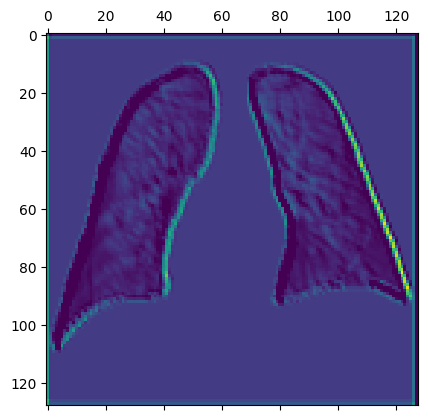

In [98]:
#Création de la heatmap pour l'image donnée, en utilisant la dernière couche de convolution du modèle

#Tirer et affichier une image au hasard dans le dataset Train
train_set_list = list(train_set_dir.glob('*/*.png'))
k = int(np.random.choice(len(train_set_list), 1))
img_path = str(train_set_list[k])
img = keras.utils.load_img(img_path)

#Récupérer le nom de l'image pour afficher la vraie classe
img_name = str(img_path).rsplit("/",1)[1]
real_class_name = img_name.split("-")[0]

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Print what the top predicted class is
preds = model.predict(img_array)

#Si le modèle est chargé avec sa couche de classification, utiliser la fonction standard de Keras :
#prediction = decode_predictions(preds, top=1)[0]

#Sinon, le nombre de classes est différent, on calcule à la main:
best_pred_index = preds.argmax()
prediction = train_ds.class_names[best_pred_index]

print(img_path)
print("Classe réelle : ", real_class_name)
print("Prédiction : ", prediction)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)


# Display heatmap
plt.matshow(heatmap)
plt.show()



Classe réelle :  COVID
Classe prédite par le modèle :  Viral_Pneumonia


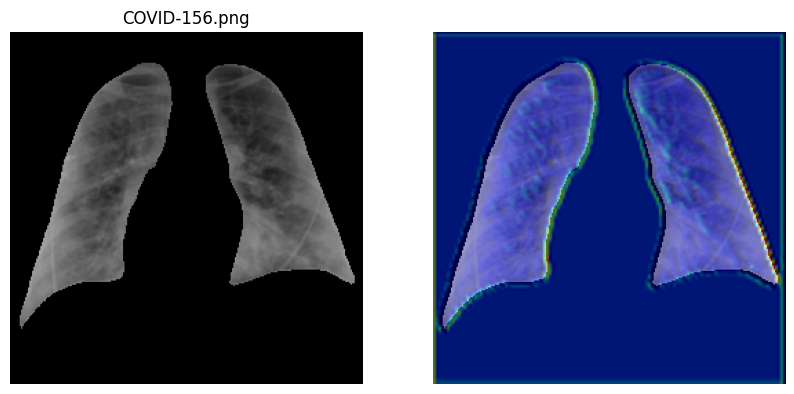

In [99]:
#Afficher les images superposées ainsi que la prédiction

#Création de la gradcam : fonctions adaptées depuis https://keras.io/examples/vision/grad_cam/
gradcam = create_gradcam(img_path, heatmap)

plt.figure(figsize = (10, 5))

#Affichage de la classe réelle et prédite
print("Classe réelle : ",real_class_name)
#fonction pour décoder la prédiction à adapter
print("Classe prédite par le modèle : ", prediction)


#Affichage de l'image source
plt.subplot(121)
plt.imshow(img, cmap = "gray")
plt.title(img_name)
plt.axis("off")

#AFfichage de la grad-cam
plt.subplot(122)
plt.imshow(gradcam)
plt.axis("off")
plt.show()
